In [108]:
import numpy as np
import pandas as pd
import matplotlib as mplt
import matplotlib.pyplot as plt
import functools

In [109]:
csvs = ["threads","fastflow","fastflow_blocking","fastflow_blocking_no_map","threads_pinned","omp"]

df = pd.concat([
        pd.read_csv("../data/threads.csv"),
        pd.read_csv("../data/fastflow.csv"),
        pd.read_csv("../data/fastflow_blocking.csv"),
        pd.read_csv("../data/fastflow_blocking_no_map.csv"),
        pd.read_csv("../data/threads_pinned.csv"),
        pd.read_csv("../data/omp.csv")
        ]).reset_index()
sequentials = pd.read_csv("../data/sequential.csv").reset_index()

In [110]:
df = df[df['nworkers'] >= 2]
df['nworkers'] -= 1

programs = df['name'].unique()
all_n_workers = df['nworkers'].unique()
filenames = df['filename'].unique()

def crop_slash(e): return e.split('/')[1].split('.')[0]

programs = [('threads',                  'd', '-'),
            ('threads_pinned',           's', '-'),
            ('fastflow',                 '^', '-'),
            ('fastflow_blocking',        'v', '-'),
            ('fastflow_blocking_no_map', 'P', '-'),
            ('omp',                      '*', '-')]

In [111]:
sequentials['read_time'] = [9326,2636,1104]
sequentials['init_time'] = [173849,62852,35543]
sequentials['total_time'] = [66790000,9810000,2080000]
sequentials['processing_time'] = [72292,25126,9525]
sequentials['frames'] = [816,431,227]

# Read timings

videos/test_big.mp4 9547 6576 31.119723473342408 %
videos/test_mid.mp4 2147 2060 4.052165812761999 %
videos/test_small.mp4 1077 1040 3.435468895078919 %


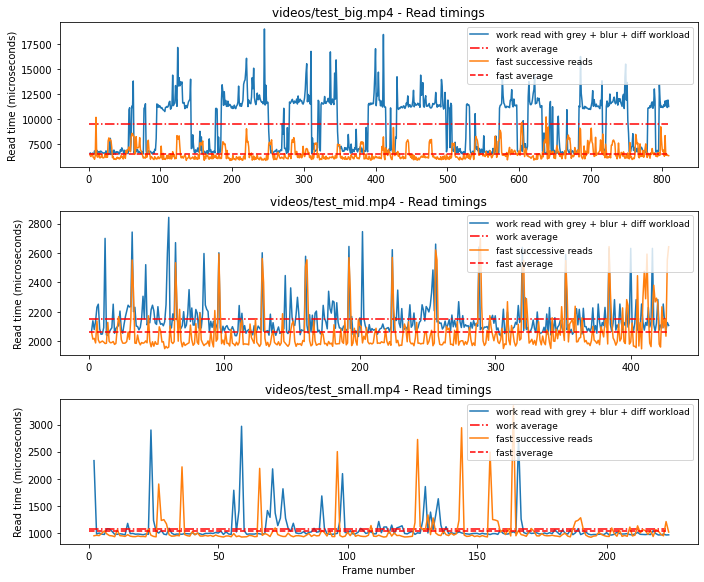

In [112]:
works, fasts = [], []
for i, f in enumerate(filenames):
    fast = pd.read_csv(f"../data/fast_read_{crop_slash(f)}.csv").head(-2).tail(-2)
    work = pd.read_csv(f"../data/work_read_{crop_slash(f)}.csv").head(-2).tail(-2)  
    #if i != 2:
    plt.subplot(3, 1, i+1)
    plt.gcf().tight_layout()
    plt.gcf().set_size_inches(10, 8)
    line, = plt.plot(work,label='work read with grey + blur + diff workload')
    plt.hlines(work['time'].mean(), xmin=0, xmax=len(work), color='red', linestyles="-.", label='work average')
    line, = plt.plot(fast,label='fast successive reads')
    plt.hlines(fast['time'].mean(), xmin=0, xmax=len(fast), color='red', linestyles="--", label='fast average')
    plt.legend(loc=1, prop={'size': 9})
    plt.ylabel("Read time (microseconds)")
    if i == 2:
        plt.xlabel("Frame number")
    plt.title(f"{f} - Read timings")

    print(f,int(work['time'].mean()),int(fast['time'].mean()),100*(1-int(fast['time'].mean())/int(work['time'].mean())),'%')

    works += [int(work['time'].mean())]
    fasts += [int(fast['time'].mean())]

sequentials['work_read_time'] = sequentials['read_time']
sequentials['fast_read_time'] = fasts

plt.savefig(f'read_timings.svg',bbox_inches='tight')
plt.show()

In [113]:
def size(): plt.gcf().set_size_inches(9, 10)

# Speedup

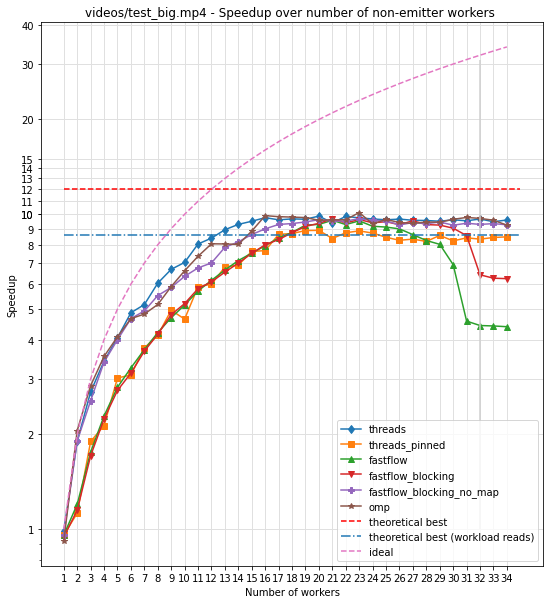

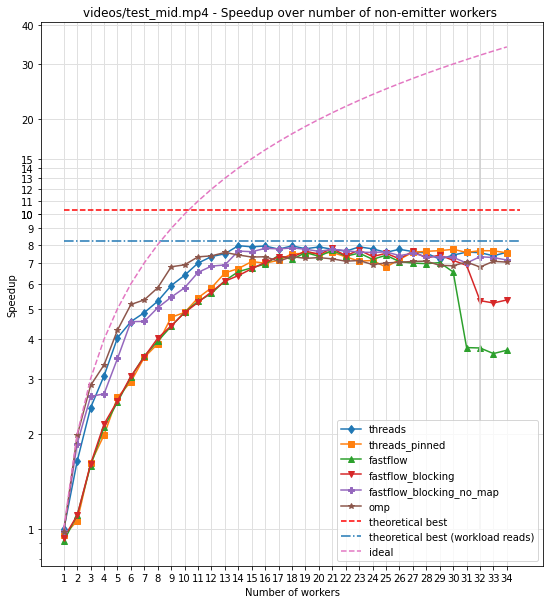

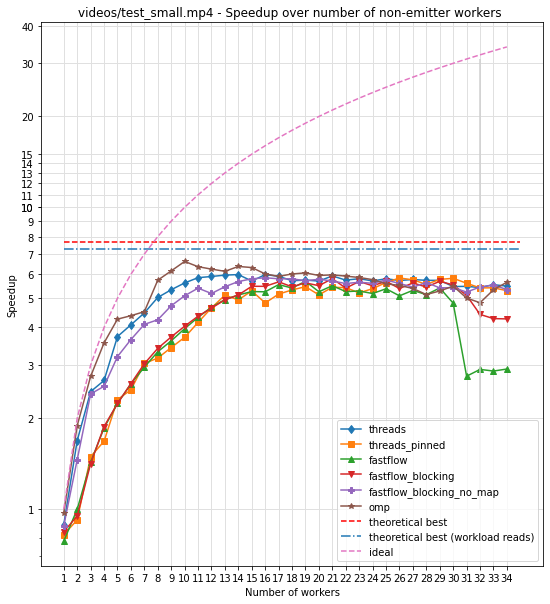

Video name & max speedup fast & max speedup work
videos/test_big.mp4 & 12.05625046819733 & 8.580570192314486
videos/test_mid.mp4 & 10.31858228359377 & 8.182036551434233
videos/test_small.mp4 & 7.657672582955052 & 7.268889502395588



In [114]:
s = "Video name & max speedup fast & max speedup work\n"
for f in filenames:
    size()
    def seq(n): return sequentials[sequentials['filename'] == f][n].values[0]

    max_speedup_fast = seq('total_time') / (seq('init_time') + seq('fast_read_time') * seq('frames'))
    max_speedup_work = seq('total_time') / (seq('init_time') + seq('work_read_time') * seq('frames'))
    
    serial_time = seq('init_time') + seq('read_time') * seq('frames')
    serial_fraction = serial_time / seq('total_time')
    max_speedup = 1 / serial_fraction

    s += f"{f} & {max_speedup_fast} & {max_speedup_work}\n"

    for p, m, d in programs:
        y = seq('total_time')/df[(df['name'] == 'bin/'+p) & (df['filename'] == f)]['avg']
        plt.plot(all_n_workers, y, d, label=p, marker=m)
    plt.grid(color='#e0e0e0', linestyle='-', linewidth=1)
    plt.yscale('log') 
    plt.yticks(list(range(0,16,1)) + list(range(10,100,10)))
    plt.gca().get_yaxis().set_major_formatter(mplt.ticker.ScalarFormatter())
    plt.gca().get_yaxis().get_major_formatter().labelOnlyBase = False
    plt.vlines(32, ymin=1, ymax=31, color='#d0d0d0', linestyle='-')
    
    plt.hlines(max_speedup_fast, xmin=1, xmax=35, linestyle='--', color='red', label='theoretical best')
    plt.hlines(max_speedup_work, xmin=1, xmax=35, linestyle='-.', label='theoretical best (workload reads)')

    plt.plot(all_n_workers, all_n_workers, '--', label='ideal')
    plt.xticks(all_n_workers)

    plt.legend()
    plt.ylabel("Speedup")
    plt.xlabel("Number of workers")
    plt.title(f"{f} - Speedup over number of non-emitter workers ")
    plt.savefig(f'speedup_{crop_slash(f)}.svg',bbox_inches='tight')    
    plt.show()

print(s)

# Completion time

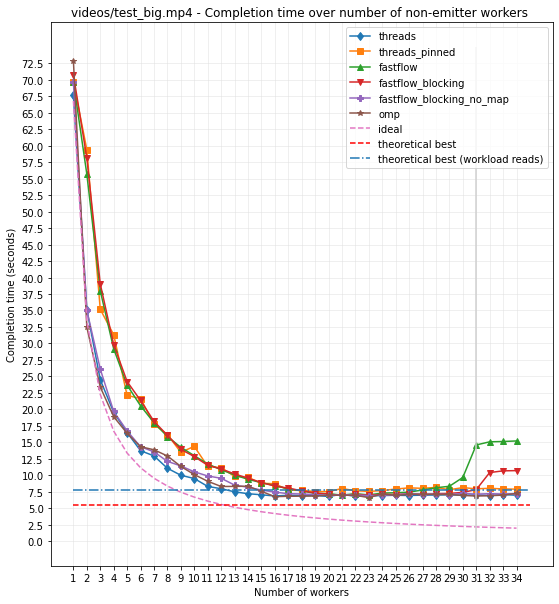

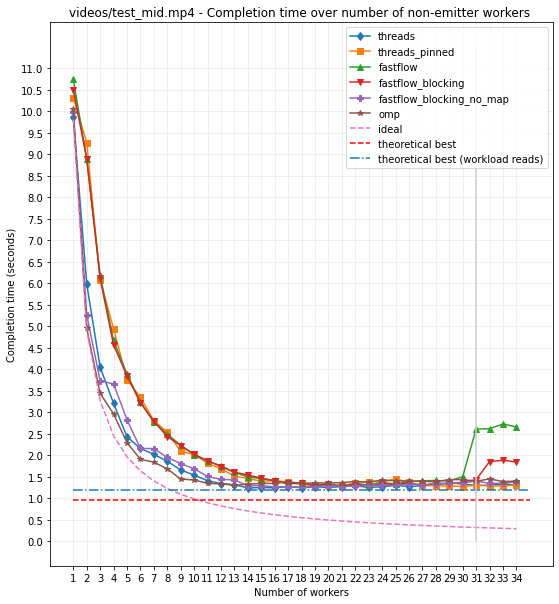

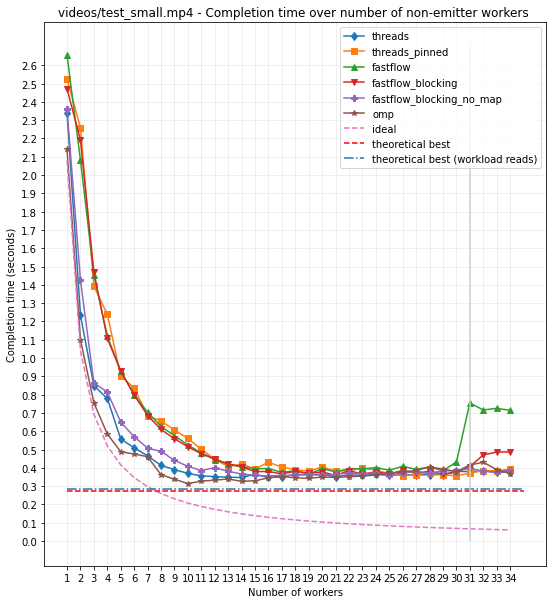

Video name & min completion time fast & min completion time work
videos/test_big.mp4 & 5539865 & 7783865
videos/test_mid.mp4 & 950712 & 1198968
videos/test_small.mp4 & 271623 & 286151



In [115]:
s = "Video name & min completion time fast & min completion time work\n"
for f in filenames:
    size()
    def seq(n): return sequentials[sequentials['filename'] == f][n].values[0]

    min_completion_time_work = seq('init_time') + seq('work_read_time') * seq('frames')
    min_completion_time_fast = seq('init_time') + seq('fast_read_time') * seq('frames')

    s += f"{f} & {min_completion_time_fast} & {min_completion_time_work}\n"

    for p, m, d in programs:
        data = df[(df['name'] == 'bin/'+p) & (df['filename'] == f)]
        y = data['avg']
        #e = df[(df['name'] == p) & (df['filename'] == f)]['std']
        plt.plot(all_n_workers, y/1e6, d, label=p, marker=m)
    plt.grid(color='#e0e0e0', linestyle='-', linewidth=0.5)
    plt.plot(all_n_workers, seq('total_time')/1e6/all_n_workers, '--', label='ideal')
    plt.xticks(all_n_workers)
    
    plt.hlines(min_completion_time_fast/1e6, xmin=1, xmax=35, linestyle='--', color='red', label='theoretical best')
    plt.hlines(min_completion_time_work/1e6, xmin=1, xmax=35, linestyle='-.', label='theoretical best (workload reads)')
    
    if f == 'videos/test_big.mp4':
        plt.yticks([x*2.5 for x in range(0,30,1)])
        plt.vlines(31, ymin=0, ymax=30*2.5, color='#d0d0d0', linestyle='-')
    if f == 'videos/test_mid.mp4':
        plt.yticks([x*0.5 for x in range(0,23,1)])
        plt.vlines(31, ymin=0, ymax=23*0.5, color='#d0d0d0', linestyle='-')
    if f == 'videos/test_small.mp4':
        plt.yticks([x*0.1 for x in range(0,27,1)])
        plt.vlines(31, ymin=0, ymax=27*0.1, color='#d0d0d0', linestyle='-')

    plt.legend()
    plt.ylabel("Completion time (seconds)")
    plt.xlabel("Number of workers")
    plt.title(f"{f} - Completion time over number of non-emitter workers ")
    plt.savefig(f'completion_time_{crop_slash(f)}.svg',bbox_inches='tight')    
    plt.show()
    
print(s)

# Efficiency

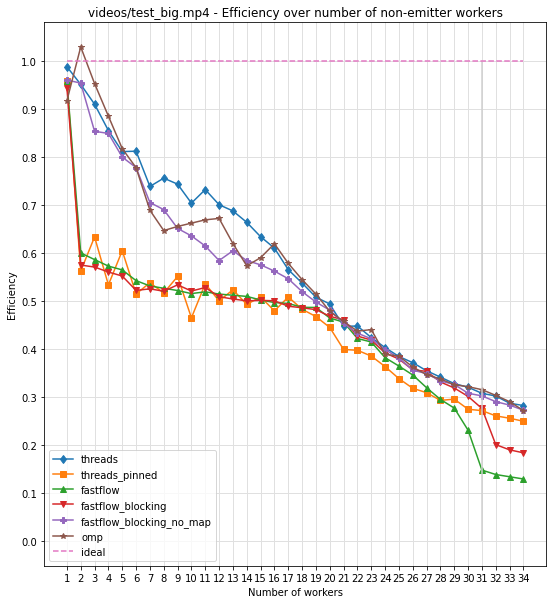

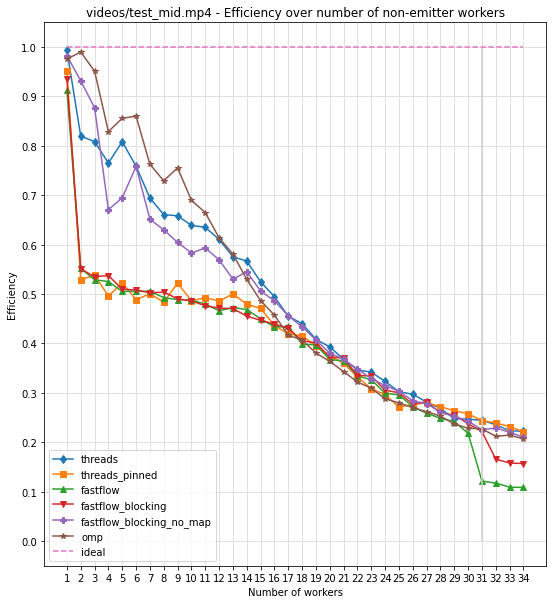

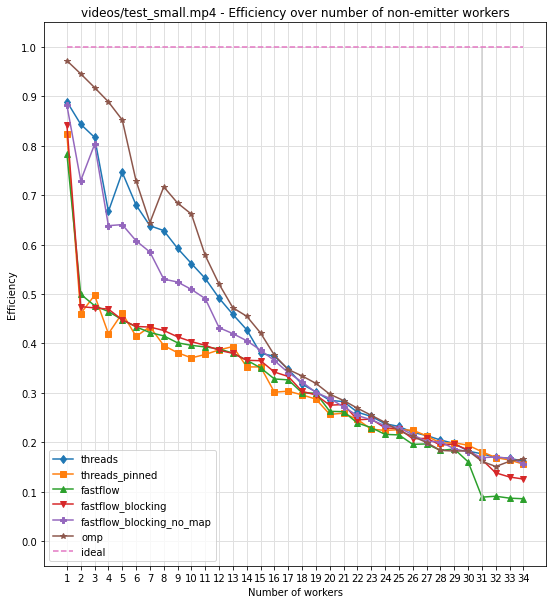

In [116]:
for f in filenames:
    size()
    def seq(n): return sequentials[sequentials['filename'] == f][n].values[0]
    for p, m, d in programs:
        y = (seq('total_time') / all_n_workers) / df[(df['name'] == 'bin/'+p) & (df['filename'] == f)]['avg']
        plt.plot(all_n_workers, y, d, label=p, marker=m)
    plt.grid(color='#e0e0e0', linestyle='-', linewidth=1)
    plt.yticks([x*0.1 for x in range(0,11,1)])
    plt.gca().get_yaxis().set_major_formatter(mplt.ticker.ScalarFormatter())
    plt.gca().get_yaxis().get_major_formatter().labelOnlyBase = False
    plt.vlines(31, ymin=0, ymax=1, color='#d0d0d0', linestyle='-')

    plt.plot(all_n_workers, all_n_workers * 0 + 1, '--', label='ideal')
    plt.xticks(all_n_workers)

    plt.legend()
    plt.ylabel("Efficiency")
    plt.xlabel("Number of workers")
    plt.title(f"{f} - Efficiency over number of non-emitter workers")
    plt.savefig(f'efficiency_{crop_slash(f)}.svg',bbox_inches='tight')  
    plt.show()

# Minimum service time

In [117]:

for p, m, d in programs:
    print(p, end=' & ')
    for f in filenames:
        def seq(n): return sequentials[sequentials['filename'] == f][n].values[0]

        min_completion_time_work = seq('init_time') + seq('work_read_time') * seq('frames')
        min_completion_time_fast = seq('init_time') + seq('fast_read_time') * seq('frames')

        data = df[(df['name'] == 'bin/'+p) & (df['filename'] == f)]
        y = (data['avg'] - seq('init_time')) / seq('frames')
        print(int(y.min()), '&', int(y.argmin()), '&', end='\t')
    print('\n')

for f in filenames:
    def seq(n): return sequentials[sequentials['filename'] == f][n].values[0]
    print(seq('fast_read_time'), end=' & ')

threads & 8081 & 19 &	2723 & 13 &	1374 & 13 &	

threads_pinned & 8993 & 19 &	2800 & 29 &	1414 & 25 &	

fastflow & 8341 & 20 &	2823 & 20 &	1454 & 18 &	

fastflow_blocking & 8253 & 20 &	2780 & 20 &	1422 & 20 &	

fastflow_blocking_no_map & 8238 & 22 &	2771 & 17 &	1411 & 15 &	

omp & 7872 & 22 &	2869 & 12 &	1228 & 9 &	

6576 & 2060 & 1040 & 